# Recommender Systems 2021/20

### Practice - SLIM MSE implemented with Python and Cython


### Cython is a superset of Python, allowing you to use C-like operations and import C code. Cython files (.pyx) are compiled and support static typing.

### Why do we use it (or any other compiled language)? If the code is written properly it is fast... I mean, FAST

In [1]:
import time
import numpy as np

### Let's implement something simple

In [2]:
def isPrime(n):
    
    i = 2
    
    # Usually you loop up to sqrt(n)
    while i < n:
        if n % i == 0:
            return False
        
        i += 1
        
    return True

In [3]:
print("Is prime 2? {}".format(isPrime(2)))
print("Is prime 3? {}".format(isPrime(3)))
print("Is prime 5? {}".format(isPrime(5)))
print("Is prime 15? {}".format(isPrime(15)))
print("Is prime 20? {}".format(isPrime(20)))

Is prime 2? True
Is prime 3? True
Is prime 5? True
Is prime 15? False
Is prime 20? False


In [4]:
start_time = time.time()

result = isPrime(80000023)

print("Is Prime 80000023? {}, time required {:.2f} sec".format(result, time.time()-start_time))

Is Prime 80000023? True, time required 9.70 sec


#### Load Cython magic command, this takes care of the compilation step. If you are writing code outside Jupyter you'll have to compile using other tools. See at the end of the notebook for details.

In [5]:
%pip install Cython
%load_ext Cython


[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Declare Cython function, paste the same code as before. The function will be compiled and then executed with a Python interface

In [6]:
%%cython
def isPrime(n):
    
    i = 2
    
    # Usually you loop up to sqrt(n)
    while i < n:
        if n % i == 0:
            return False
        
        i += 1
        
    return True

In [7]:
start_time = time.time()

result = isPrime(80000023)

print("Is Prime 80000023? {}, time required {:.2f} sec".format(result, time.time()-start_time))

Is Prime 80000023? True, time required 4.52 sec


#### As you can see by just compiling the same code we got some improvement.
#### To go seriously higher, we have to use some static tiping

In [8]:
%%cython
# Declare the tipe of the arguments
def isPrime(long n):
    
    # Declare index of for loop
    cdef long i
    
    i = 2
    
    # Usually you loop up to sqrt(n)
    while i < n:
        if n % i == 0:
            return False
        
        i += 1
        
    return True

In [9]:
start_time = time.time()

result = isPrime(80000023)

print("Is Prime 80000023? {}, time required {:.2f} sec".format(result, time.time()-start_time))

Is Prime 80000023? True, time required 0.26 sec


#### Cython code with two tipe declaration, for n and i, runs 50x faster than Python

#### Main benefits of Cython:
* Compiled, no interpreter
* Static typing, no overhead
* Fast loops, no need to vectorize. Vectorization sometimes performes lots of useless operations
* Numpy, which is fast in python, when opertions are not vectorizable often becomes slooooow compared to a carefully written Cython code

## A few info about gradient descent

In [10]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.optimize import fmin

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; choose $\alpha_k$ to minimize $f(x_k+\alpha_k s_k)$ <br>
&nbsp;&nbsp;&nbsp;    5:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha_k s_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [11]:
f = lambda x: x**3-2*x**2+2

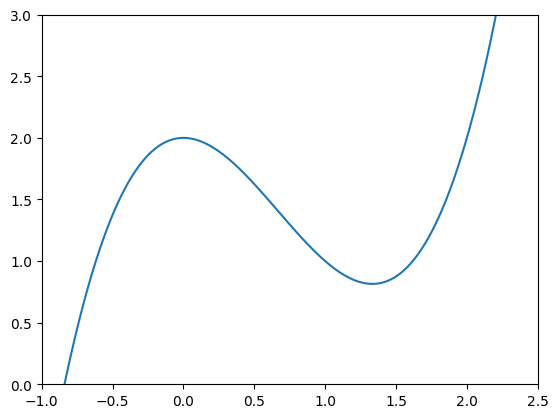

In [12]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

We can see from plot above that our local minimum is gonna be near around 1.4 or 1.5 (on the x-axis), but let's pretend that we don't know that, so we set our starting point (arbitrarily, in this case) at $x_0 = 2$

In [13]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_gradient(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    
    x_old = x_new
    
    # Gradient descent step
    s_k = -f_gradient(x_old)
    
    x_new = x_old + n_k * s_k
    
    x_list.append(x_new)
    y_list.append(f(x_new))
    
print ("Local minimum occurs at: {:.2f}".format(x_new))
print ("Number of steps:", len(x_list))

Local minimum occurs at: 1.33
Number of steps: 17


The figures below show the route that was taken to find the local minimum.

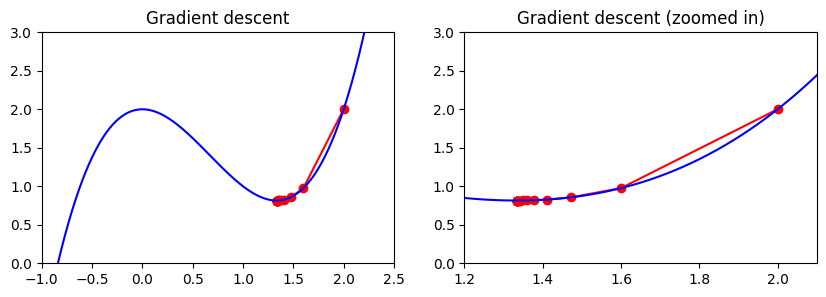

In [14]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([0,3])
plt.title("Gradient descent (zoomed in)")
plt.show()

# SLIM MSE with Cython

#### Load the usual data.

In [15]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from challenge.utils import functions as f
import scipy.sparse as sps


data_file_path = '../challenge/input_files/data_train.csv'
users_file_path = '../challenge/input_files/data_target_users_test.csv'

URM_all_dataframe, users_list = f.read_data(data_file_path, users_file_path)

URM_all = sps.coo_matrix(
    (URM_all_dataframe['Data'].values, (URM_all_dataframe['UserID'].values, URM_all_dataframe['ItemID'].values)))
URM_all = URM_all.tocsr()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)

In [16]:
URM_train

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>

## What do we need for a SLIM MSE?

* Loss function
* Item-Item similarity matrix
* Computing prediction
* Update rule
* Training loop and some patience


In [17]:
n_users, n_items = URM_train.shape

#### SLIM MSE is based on a dense item-item similarity matrix $ S \in R^{I \times I}$ 

### How to compute the predictions
$ \hat{r}_{ui} = \sum_{j=0}^{I} r_{uj}S_{ji}$


### The loss function we are interested in minimizing is

$L = |R - RS|_2 + \alpha|S|_2 + \beta|S|$

#### The gradient of this with respect to S is
$\frac{\partial}{\partial S} L = -2(R - RS)R + 2 \alpha S + \beta$

#### The update is going to be (we can remove the coefficients)
$ S = S - \frac{\partial}{\partial S}$, or 

$ S = S + l((R - RS)R - \alpha S - \beta)$, with $l$ the learning rate

### WARNING:
During the learning process we must account for the fact that a possible solution for SLIM EN is $S=I$, which is a trivial and useless solution. We want to avoid that the diagonal is 1. This can be done by either introducing a penalty in the loss function or by simply never using and updating the diagonal. In this notebook we will never learn the self-similarity (the similarity of an item with itself, i.e., the diagonal) by ensuring it is always zero.

## Step 1: We create a dense similarity matrix, initialized as zero

In [18]:
item_item_S = np.zeros((n_items, n_items), dtype = float)
item_item_S

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Step 2: We sample an interaction and compute the prediction of the current SLIM model

In [19]:
URM_train_coo = URM_train.tocoo()

sample_index = np.random.randint(URM_train_coo.nnz)
sample_index

182209

In [20]:
user_id = URM_train_coo.row[sample_index]
item_id = URM_train_coo.col[sample_index]
true_rating = URM_train_coo.data[sample_index]

(user_id, item_id, true_rating)

(6154, 1500, 1.0)

In [21]:
predicted_rating = URM_train[user_id].dot(item_item_S[:,item_id])[0]
predicted_rating

0.0

#### The first predicted rating is zero, of course, the model is "empty"

### Step 3: We compute the prediction error and update the item-item similarity

In [22]:
prediction_error = true_rating - predicted_rating
prediction_error

1.0

### The error is positive, so we need to increase the prediction our model computes. Meaning, we have to increase the values in the item-item similarity matrix

### Which item similarities we modify? Only those we used to compute the prediction, i.e., only the items in the profile of the sampled user. 

In [23]:
items_in_user_profile = URM_train[user_id].indices
items_in_user_profile

array([    5,     9,    11,    16,    17,    28,    31,    37,    39,
          42,    76,    91,   122,   124,   158,   197,   210,   244,
         257,   258,   269,   287,   291,   308,   321,   328,   388,
         390,   411,   450,   476,   496,   533,   547,   557,   612,
         630,   653,   686,   707,   713,   714,   729,   733,   742,
         853,   870,   915,   932,   937,   975,   983,   994,  1017,
        1071,  1090,  1127,  1129,  1143,  1190,  1204,  1267,  1311,
        1345,  1370,  1415,  1438,  1480,  1500,  1519,  1551,  1604,
        1616,  1620,  1670,  1696,  1700,  1719,  1776,  1869,  1939,
        1949,  1995,  2021,  2043,  2047,  2051,  2056,  2082,  2118,
        2196,  2229,  2355,  2366,  2411,  2472,  2495,  2708,  2712,
        2728,  2745,  2830,  2850,  2897,  2952,  2964,  3006,  3008,
        3087,  3112,  3207,  3488,  3579,  3604,  3648,  3695,  3842,
        3998,  4082,  4160,  4290,  4348,  4669,  4904,  4973,  4985,
        5140,  5191,

In [24]:
ratings_in_user_profile = URM_train[user_id].data
ratings_in_user_profile

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

#### Apply the update rule

In [25]:
item_item_S[items_in_user_profile,item_id]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [26]:
learning_rate = 1e-4
regularization_2 = 1e-3

# let's simplify and only use the l2 norm for regularization
item_item_S[items_in_user_profile,item_id] += learning_rate * (prediction_error * ratings_in_user_profile -
                                                               regularization_2 * item_item_S[items_in_user_profile,item_id])

# Ensure diagonal is always zero
item_item_S[item_id,item_id] = 0.0

In [27]:
item_item_S[items_in_user_profile,item_id]

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.    , 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
      

### Let's check what the new prediction for the same user-item interaction would be

In [28]:
predicted_rating = URM_train[user_id].dot(item_item_S[:,item_id])[0]
predicted_rating

0.026799999999999893

### The value is not zero anymore, but higher, we are moving in the right direction

### And now? Sample another interaction and repeat... a lot of times

### Let's put all together in a training loop.

In [29]:
URM_train_coo = URM_train.tocoo()
item_item_S = np.zeros((n_items, n_items), dtype = float)

learning_rate = 1e-6
regularization_2 = 1e-3

loss = 0.0
start_time = time.time()
for sample_num in range(100000):
    
    # Randomly pick sample
    sample_index = np.random.randint(URM_train_coo.nnz)

    user_id = URM_train_coo.row[sample_index]
    item_id = URM_train_coo.col[sample_index]
    true_rating = URM_train_coo.data[sample_index]

    # Compute prediction
    predicted_rating = URM_train[user_id].dot(item_item_S[:,item_id])[0]
        
    # Compute prediction error, or gradient
    prediction_error = true_rating - predicted_rating
    loss += prediction_error**2
    
    # Update model, in this case the similarity
    items_in_user_profile = URM_train[user_id].indices
    ratings_in_user_profile = URM_train[user_id].data
    item_item_S[items_in_user_profile,item_id] += learning_rate * (prediction_error * ratings_in_user_profile -
                                                                   regularization_2 * item_item_S[items_in_user_profile,item_id])
    
    # Ensure diagonal is always zero
    item_item_S[item_id,item_id] = 0.0

    # Print some stats
    if (sample_num +1)% 5000 == 0:
        elapsed_time = time.time() - start_time
        samples_per_second = (sample_num +1)/elapsed_time
        print("Iteration {} in {:.2f} seconds, loss is {:.2f}. Samples per second {:.2f}".format(sample_num+1, elapsed_time, loss/(sample_num +1), samples_per_second))


Iteration 5000 in 34.67 seconds, loss is 1.00. Samples per second 144.22
Iteration 10000 in 68.89 seconds, loss is 1.00. Samples per second 145.16
Iteration 15000 in 82.68 seconds, loss is 1.00. Samples per second 181.41
Iteration 20000 in 94.01 seconds, loss is 1.00. Samples per second 212.74
Iteration 25000 in 105.53 seconds, loss is 1.00. Samples per second 236.91
Iteration 30000 in 116.28 seconds, loss is 1.00. Samples per second 257.99
Iteration 35000 in 126.80 seconds, loss is 1.00. Samples per second 276.03
Iteration 40000 in 134.06 seconds, loss is 1.00. Samples per second 298.38
Iteration 45000 in 139.55 seconds, loss is 1.00. Samples per second 322.46
Iteration 50000 in 147.54 seconds, loss is 1.00. Samples per second 338.90
Iteration 55000 in 156.28 seconds, loss is 1.00. Samples per second 351.93
Iteration 60000 in 161.75 seconds, loss is 1.00. Samples per second 370.94
Iteration 65000 in 168.50 seconds, loss is 1.00. Samples per second 385.75
Iteration 70000 in 174.02 seco

### What do we see? The loss generally goes down but may oscillate a bit.
### How long do we train such a model?

* An epoch: a complete loop over all the train data
* Usually you train for multiple epochs. Depending on the algorithm and data 10s or 100s of epochs.

In [30]:
def train_one_epoch(URM_train, item_item_S, learning_rate, regularization_2):
    
    URM_train_coo = URM_train.tocoo()

    loss = 0.0
    start_time = time.time()
    for sample_num in range(URM_train.nnz):

        # Randomly pick sample
        sample_index = np.random.randint(URM_train_coo.nnz)

        user_id = URM_train_coo.row[sample_index]
        item_id = URM_train_coo.col[sample_index]
        true_rating = URM_train_coo.data[sample_index]

        # Compute prediction
        predicted_rating = URM_train[user_id].dot(item_item_S[:,item_id])[0]

        # Compute prediction error, or gradient
        prediction_error = true_rating - predicted_rating
        loss += prediction_error**2

        # Update model, in this case the similarity
        items_in_user_profile = URM_train[user_id].indices
        ratings_in_user_profile = URM_train[user_id].data
        item_item_S[items_in_user_profile,item_id] += learning_rate * (prediction_error * ratings_in_user_profile -
                                                                       regularization_2 * item_item_S[items_in_user_profile,item_id])

        # Ensure diagonal is always zero
        item_item_S[item_id,item_id] = 0.0
    
        # Print some stats
        if (sample_num +1)% 5000 == 0:
            elapsed_time = time.time() - start_time
            samples_per_second = (sample_num +1)/elapsed_time
            print("Iteration {} in {:.2f} seconds, loss is {:.2f}. Samples per second {:.2f}".format(sample_num+1, elapsed_time, loss/(sample_num +1), samples_per_second))
         
            # Stop training because this implementation is too slow
            print("\tStopping the epoch early because this implementation is too slow")
            return item_item_S
            
    return item_item_S

In [31]:
n_items = URM_train.shape[1]
learning_rate = 1e-6
regularization_2 = 1e-3
    
item_item_S = np.zeros((n_items, n_items), dtype = float)

for n_epoch in range(5):
    item_item_S = train_one_epoch(URM_train, item_item_S, learning_rate, regularization_2)
    

Iteration 5000 in 7.18 seconds, loss is 1.00. Samples per second 696.15
	Stopping the epoch early because this implementation is too slow
Iteration 5000 in 5.49 seconds, loss is 1.00. Samples per second 910.85
	Stopping the epoch early because this implementation is too slow
Iteration 5000 in 6.08 seconds, loss is 1.00. Samples per second 822.09
	Stopping the epoch early because this implementation is too slow
Iteration 5000 in 5.37 seconds, loss is 1.00. Samples per second 931.38
	Stopping the epoch early because this implementation is too slow
Iteration 5000 in 5.61 seconds, loss is 1.00. Samples per second 891.46
	Stopping the epoch early because this implementation is too slow


In [32]:
item_item_S

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.09978689e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.29994279e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### How do we use this similarity? As in a simple item-based KNN

### Let's estimate the training time. Say we train for 10 epochs and we have 8M interactions in the train data...

In [33]:
estimated_seconds = 8e6 * 10 / samples_per_second
print("Estimated time with the previous training speed is {:.2f} seconds ({:.2f} minutes, {:.2f} hours)".format(estimated_seconds, estimated_seconds/60, estimated_seconds/3600))

Estimated time with the previous training speed is 168998.61 seconds (2816.64 minutes, 46.94 hours)


### Unacceptable!

### Let's rewrite the loop with some smarter use of the data structures. In particular:
* Use the indptr/indices data structures to get the seen items
* Not much else we can do with this tools

In [34]:
URM_train_coo = URM_train.tocoo()
item_item_S = np.zeros((n_items, n_items), dtype = float)

learning_rate = 1e-6
regularization_2 = 1e-3

loss = 0.0
start_time = time.time()
for sample_num in range(100000):
    
    # Randomly pick sample
    sample_index = np.random.randint(URM_train_coo.nnz)

    user_id = URM_train_coo.row[sample_index]
    item_id = URM_train_coo.col[sample_index]
    true_rating = URM_train_coo.data[sample_index]

    # Compute prediction
    predicted_rating = URM_train[user_id].dot(item_item_S[:,item_id])[0]
        
    # Compute prediction error, or gradient
    prediction_error = true_rating - predicted_rating
    loss += prediction_error**2
    
    # Update model, in this case the similarity
    items_in_user_profile = URM_train.indices[URM_train.indptr[user_id]:URM_train.indptr[user_id+1]]
    ratings_in_user_profile = URM_train.data[URM_train.indptr[user_id]:URM_train.indptr[user_id+1]]
    item_item_S[items_in_user_profile,item_id] += learning_rate * (prediction_error * ratings_in_user_profile -
                                                                   regularization_2 * item_item_S[items_in_user_profile,item_id])
    
    # Ensure diagonal is always zero
    item_item_S[item_id,item_id] = 0.0
    
    # Print some stats
    if (sample_num +1)% 5000 == 0:
        elapsed_time = time.time() - start_time
        samples_per_second = (sample_num +1)/elapsed_time
        print("Iteration {} in {:.2f} seconds, loss is {:.2f}. Samples per second {:.2f}".format(sample_num+1, elapsed_time, loss/(sample_num +1), samples_per_second))


Iteration 5000 in 14.28 seconds, loss is 1.00. Samples per second 350.19
Iteration 10000 in 21.25 seconds, loss is 1.00. Samples per second 470.51
Iteration 15000 in 31.17 seconds, loss is 1.00. Samples per second 481.24
Iteration 20000 in 36.73 seconds, loss is 1.00. Samples per second 544.51
Iteration 25000 in 44.20 seconds, loss is 1.00. Samples per second 565.63
Iteration 30000 in 49.56 seconds, loss is 1.00. Samples per second 605.31
Iteration 35000 in 55.56 seconds, loss is 1.00. Samples per second 629.94
Iteration 40000 in 62.24 seconds, loss is 1.00. Samples per second 642.66
Iteration 45000 in 68.40 seconds, loss is 1.00. Samples per second 657.85
Iteration 50000 in 74.63 seconds, loss is 1.00. Samples per second 669.95
Iteration 55000 in 79.86 seconds, loss is 1.00. Samples per second 688.71
Iteration 60000 in 87.21 seconds, loss is 1.00. Samples per second 688.03
Iteration 65000 in 92.95 seconds, loss is 1.00. Samples per second 699.34
Iteration 70000 in 98.18 seconds, loss 

In [35]:
estimated_seconds = 8e6 * 10 / samples_per_second
print("Estimated time with the previous training speed is {:.2f} seconds ({:.2f} minutes, {:.2f} hours)".format(estimated_seconds, estimated_seconds/60, estimated_seconds/3600))

Estimated time with the previous training speed is 109380.28 seconds (1823.00 minutes, 30.38 hours)


### Just as bad as before

### Let's see what we can do with Cython
### First step, just compile it. We do not have the data at compile time, so we put the loop in a function

In [36]:
%%cython
import numpy as np
import time

def do_some_training(URM_train):
    
    URM_train_coo = URM_train.tocoo()
    n_items = URM_train.shape[1]
    
    item_item_S = np.zeros((n_items, n_items), dtype = float)

    learning_rate = 1e-6
    regularization_2 = 1e-3

    loss = 0.0
    start_time = time.time()
    for sample_num in range(100000):

        # Randomly pick sample
        sample_index = np.random.randint(URM_train_coo.nnz)

        user_id = URM_train_coo.row[sample_index]
        item_id = URM_train_coo.col[sample_index]
        true_rating = URM_train_coo.data[sample_index]

        # Compute prediction
        predicted_rating = URM_train[user_id].dot(item_item_S[:,item_id])[0]

        # Compute prediction error, or gradient
        prediction_error = true_rating - predicted_rating
        loss += prediction_error**2

        # Update model, in this case the similarity
        items_in_user_profile = URM_train.indices[URM_train.indptr[user_id]:URM_train.indptr[user_id+1]]
        ratings_in_user_profile = URM_train.data[URM_train.indptr[user_id]:URM_train.indptr[user_id+1]]
        item_item_S[items_in_user_profile,item_id] += learning_rate * (prediction_error * ratings_in_user_profile -
                                                                       regularization_2 * item_item_S[items_in_user_profile,item_id])

        # Ensure diagonal is always zero
        item_item_S[item_id,item_id] = 0.0
    
        # Print some stats
        if (sample_num +1)% 5000 == 0:
            elapsed_time = time.time() - start_time
            samples_per_second = (sample_num +1)/elapsed_time
            print("Iteration {} in {:.2f} seconds, loss is {:.2f}. Samples per second {:.2f}".format(sample_num+1, elapsed_time, loss/(sample_num +1), samples_per_second))
    
    return loss, samples_per_second

In [37]:
loss, samples_per_second = do_some_training(URM_train)

Iteration 5000 in 11.77 seconds, loss is 1.00. Samples per second 424.95
Iteration 10000 in 18.98 seconds, loss is 1.00. Samples per second 526.82
Iteration 15000 in 25.50 seconds, loss is 1.00. Samples per second 588.23
Iteration 20000 in 32.13 seconds, loss is 1.00. Samples per second 622.40
Iteration 25000 in 38.89 seconds, loss is 1.00. Samples per second 642.85
Iteration 30000 in 44.67 seconds, loss is 1.00. Samples per second 671.56
Iteration 35000 in 50.13 seconds, loss is 1.00. Samples per second 698.21
Iteration 40000 in 55.37 seconds, loss is 1.00. Samples per second 722.46
Iteration 45000 in 60.94 seconds, loss is 1.00. Samples per second 738.42
Iteration 50000 in 66.13 seconds, loss is 1.00. Samples per second 756.12
Iteration 55000 in 71.36 seconds, loss is 1.00. Samples per second 770.79
Iteration 60000 in 77.75 seconds, loss is 1.00. Samples per second 771.69
Iteration 65000 in 83.17 seconds, loss is 1.00. Samples per second 781.53
Iteration 70000 in 88.34 seconds, loss 

In [38]:
estimated_seconds = 8e6 * 10 / samples_per_second
print("Estimated time with the previous training speed is {:.2f} seconds ({:.2f} minutes, {:.2f} hours)".format(estimated_seconds, estimated_seconds/60, estimated_seconds/3600))

Estimated time with the previous training speed is 96492.31 seconds (1608.21 minutes, 26.80 hours)


### Still far too time consuming
### The compiler is just porting in C all operations that the python interpreter would have to perform, dynamic tiping included. Have a look at the html reports in the Cython_examples folder

### Now try to add some types: If you use a variable only as a C object, use primitive tipes

* cdef int namevar
* cdef double namevar
* cdef float namevar
* cdef double[:] singledimensionarray
* cdef double[:,:] bidimensionalmatrix


### We now use types for all main variables


In [39]:
%%cython
import numpy as np
import time

def do_some_training(URM_train):

    URM_train_coo = URM_train.tocoo()
    n_items = URM_train.shape[1]

    cdef double[:,:] item_item_S = np.zeros((n_items, n_items), dtype = float)
    cdef double learning_rate = 1e-6, regularization_2 = 1e-3
    cdef double loss = 0.0
    cdef long start_time = time.time()
    cdef double true_rating, predicted_rating, prediction_error, profile_rating
    cdef int[:] items_in_user_profile
    cdef double[:] ratings_in_user_profile
    cdef int index, sample_num, user_id, item_id, profile_item_id

    for sample_num in range(100000):

        # Randomly pick sample
        sample_index = np.random.randint(URM_train_coo.nnz)

        user_id = URM_train_coo.row[sample_index]
        item_id = URM_train_coo.col[sample_index]
        true_rating = URM_train_coo.data[sample_index]

        # Compute prediction
        items_in_user_profile = URM_train.indices[URM_train.indptr[user_id]:URM_train.indptr[user_id+1]]
        ratings_in_user_profile = URM_train.data[URM_train.indptr[user_id]:URM_train.indptr[user_id+1]]
        predicted_rating = 0.0

        for index in range(len(items_in_user_profile)):
            profile_item_id = items_in_user_profile[index]
            profile_rating = ratings_in_user_profile[index]
            predicted_rating += profile_rating * item_item_S[profile_item_id,item_id]

        # Compute prediction error, or gradient
        prediction_error = true_rating - predicted_rating
        loss += prediction_error**2

        # Update model, in this case the similarity
        for index in range(len(items_in_user_profile)):
            profile_item_id = items_in_user_profile[index]
            profile_rating = ratings_in_user_profile[index]
            item_item_S[profile_item_id,item_id] += learning_rate * (prediction_error * profile_rating -
                                                                     regularization_2 * item_item_S[profile_item_id,item_id])

        # Ensure diagonal is always zero
        item_item_S[item_id,item_id] = 0.0
    
        # Print some stats
        if (sample_num +1)% 5000 == 0:
            elapsed_time = time.time() - start_time
            samples_per_second = (sample_num +1)/elapsed_time
            print("Iteration {} in {:.2f} seconds, loss is {:.2f}. Samples per second {:.2f}".format(sample_num+1, elapsed_time, loss/(sample_num +1), samples_per_second))

    return loss, samples_per_second

In [40]:
loss, samples_per_second = do_some_training(URM_train)

Iteration 5000 in 1.25 seconds, loss is 1.00. Samples per second 4009.57
Iteration 10000 in 1.51 seconds, loss is 1.00. Samples per second 6607.73
Iteration 15000 in 1.74 seconds, loss is 1.00. Samples per second 8627.51
Iteration 20000 in 1.90 seconds, loss is 1.00. Samples per second 10499.98
Iteration 25000 in 2.06 seconds, loss is 1.00. Samples per second 12163.23
Iteration 30000 in 2.19 seconds, loss is 1.00. Samples per second 13711.74
Iteration 35000 in 2.31 seconds, loss is 1.00. Samples per second 15141.02
Iteration 40000 in 2.42 seconds, loss is 1.00. Samples per second 16533.74
Iteration 45000 in 2.52 seconds, loss is 1.00. Samples per second 17844.35
Iteration 50000 in 2.62 seconds, loss is 1.00. Samples per second 19057.07
Iteration 55000 in 2.72 seconds, loss is 1.00. Samples per second 20250.08
Iteration 60000 in 2.80 seconds, loss is 1.00. Samples per second 21399.82
Iteration 65000 in 2.89 seconds, loss is 1.00. Samples per second 22494.96
Iteration 70000 in 2.97 secon

In [41]:
estimated_seconds = 8e6 * 10 / samples_per_second
print("Estimated time with the previous training speed is {:.2f} seconds ({:.2f} minutes, {:.2f} hours)".format(estimated_seconds, estimated_seconds/60, estimated_seconds/3600))

Estimated time with the previous training speed is 2734.40 seconds (45.57 minutes, 0.76 hours)


### This is why we use it for machine learning algorithms...

### Some operations are still done with sparse matrices, those cannot be correctly optimized because the compiler does not know how what is the type of the data.

### To address this, we create typed arrays in which we put the URM_train data
For example, this operation: user_id = URM_train_coo.row[sample_index]

Becomes:

cdef int user_id

cdef int[:] URM_train_coo_row = URM_train_coo.row

user_id = URM_train_coo_row[sample_index]


### We can also skip the creation of the items_in_user_profile array and replace the np.random call with the faster native C function rand()

## To obtain a more reliable speed estimate we increase the number of samples and the print step by a factor of 10

In [42]:
%%cython

import numpy as np
import time

from libc.stdlib cimport rand, srand, RAND_MAX

def do_some_training(URM_train):

    URM_train_coo = URM_train.tocoo()
    cdef int n_items = URM_train.shape[1]
    cdef int n_interactions = URM_train.nnz
    cdef int[:] URM_train_coo_row = URM_train_coo.row
    cdef int[:] URM_train_coo_col = URM_train_coo.col
    cdef double[:] URM_train_coo_data = URM_train_coo.data
    cdef int[:] URM_train_indices = URM_train.indices
    cdef int[:] URM_train_indptr = URM_train.indptr
    cdef double[:] URM_train_data = URM_train.data

    cdef double[:,:] item_item_S = np.zeros((n_items, n_items), dtype = float)
    cdef double learning_rate = 1e-6, regularization_2 = 1e-3
    cdef double loss = 0.0
    cdef long start_time = time.time()
    cdef double true_rating, predicted_rating, prediction_error, profile_rating
    cdef int start_profile, end_profile
    cdef int index, sample_num, user_id, item_id, profile_item_id

    for sample_num in range(1000000):

        # Randomly pick sample
        index = rand() % n_interactions

        user_id = URM_train_coo_row[index]
        item_id = URM_train_coo_col[index]
        true_rating = URM_train_coo_data[index]

        # Compute prediction
        start_profile = URM_train_indptr[user_id]
        end_profile = URM_train_indptr[user_id+1]
        predicted_rating = 0.0

        for index in range(start_profile, end_profile):
            profile_item_id = URM_train_indices[index]
            profile_rating = URM_train_data[index]
            predicted_rating += item_item_S[profile_item_id,item_id] * profile_rating

        # Compute prediction error, or gradient
        prediction_error = true_rating - predicted_rating
        loss += prediction_error**2

        # Update model, in this case the similarity
        for index in range(start_profile, end_profile):
            profile_item_id = URM_train_indices[index]
            profile_rating = URM_train_data[index]
            item_item_S[profile_item_id,item_id] += learning_rate * (prediction_error * profile_rating - 
                                                                     regularization_2 * item_item_S[profile_item_id,item_id])

        # Ensure diagonal is always zero
        item_item_S[item_id,item_id] = 0.0
        
        # Print some stats
        if (sample_num +1)% 50000 == 0:
            elapsed_time = time.time() - start_time
            samples_per_second = (sample_num +1)/elapsed_time
            print("Iteration {} in {:.2f} seconds, loss is {:.2f}. Samples per second {:.2f}".format(sample_num+1, elapsed_time, loss/(sample_num +1), samples_per_second))

    return loss, samples_per_second

In [43]:
loss, samples_per_second = do_some_training(URM_train)

Iteration 50000 in 2.32 seconds, loss is 1.00. Samples per second 21566.64
Iteration 100000 in 2.81 seconds, loss is 1.00. Samples per second 35601.85
Iteration 150000 in 3.14 seconds, loss is 1.00. Samples per second 47804.10
Iteration 200000 in 3.41 seconds, loss is 1.00. Samples per second 58682.16
Iteration 250000 in 3.65 seconds, loss is 1.00. Samples per second 68509.69
Iteration 300000 in 3.88 seconds, loss is 1.00. Samples per second 77297.16
Iteration 350000 in 4.11 seconds, loss is 1.00. Samples per second 85200.94
Iteration 400000 in 4.33 seconds, loss is 1.00. Samples per second 92314.73
Iteration 450000 in 4.56 seconds, loss is 1.00. Samples per second 98724.46
Iteration 500000 in 4.78 seconds, loss is 1.00. Samples per second 104685.98
Iteration 550000 in 5.00 seconds, loss is 1.00. Samples per second 110081.84
Iteration 600000 in 5.25 seconds, loss is 1.00. Samples per second 114381.38
Iteration 650000 in 5.45 seconds, loss is 1.00. Samples per second 119165.23
Iteration

In [44]:
estimated_seconds = 8e6 * 10 / samples_per_second
print("Estimated time with the previous training speed is {:.2f} seconds ({:.2f} minutes, {:.2f} hours)".format(estimated_seconds, estimated_seconds/60, estimated_seconds/3600))

Estimated time with the previous training speed is 555.83 seconds (9.26 minutes, 0.15 hours)


### As the source code gets less readable due to the addition of types and native C functions, it also gets remarkably faster

### We started from a naive python implementation which took 10 hours (2k samples per second) and we now have a Cython one with takes only a few minutes (100k samples per second).

In [45]:
%%cython

import numpy as np
import time

from libc.stdlib cimport rand, srand, RAND_MAX

def train_multiple_epochs(URM_train, learning_rate_input, regularization_2_input, n_epochs):

    URM_train_coo = URM_train.tocoo()
    cdef int n_items = URM_train.shape[1]
    cdef int n_interactions = URM_train.nnz
    cdef int[:] URM_train_coo_row = URM_train_coo.row
    cdef int[:] URM_train_coo_col = URM_train_coo.col
    cdef double[:] URM_train_coo_data = URM_train_coo.data
    cdef int[:] URM_train_indices = URM_train.indices
    cdef int[:] URM_train_indptr = URM_train.indptr
    cdef double[:] URM_train_data = URM_train.data

    cdef double[:,:] item_item_S = np.zeros((n_items, n_items), dtype = float)
    cdef double learning_rate = learning_rate_input
    cdef double regularization_2 = regularization_2_input
    cdef double loss = 0.0
    cdef long start_time
    cdef double true_rating, predicted_rating, prediction_error, profile_rating
    cdef int start_profile, end_profile
    cdef int index, sample_num, user_id, item_id, profile_item_id
    
    for n_epoch in range(n_epochs):
        
        loss = 0.0
        start_time = time.time()
        
        for sample_num in range(n_interactions):

            # Randomly pick sample
            index = rand() % n_interactions

            user_id = URM_train_coo_row[index]
            item_id = URM_train_coo_col[index]
            true_rating = URM_train_coo_data[index]

            # Compute prediction
            start_profile = URM_train_indptr[user_id]
            end_profile = URM_train_indptr[user_id+1]
            predicted_rating = 0.0

            for index in range(start_profile, end_profile):
                profile_item_id = URM_train_indices[index]
                profile_rating = URM_train_data[index]
                predicted_rating += item_item_S[profile_item_id,item_id] * profile_rating

            # Compute prediction error, or gradient
            prediction_error = true_rating - predicted_rating
            loss += prediction_error**2

            # Update model, in this case the similarity
            for index in range(start_profile, end_profile):
                profile_item_id = URM_train_indices[index]
                profile_rating = URM_train_data[index]
                item_item_S[profile_item_id,item_id] += learning_rate * (prediction_error * profile_rating - 
                                                                         regularization_2 * item_item_S[profile_item_id,item_id])

            # Ensure diagonal is always zero
            item_item_S[item_id,item_id] = 0.0
        
#             if sample_num % 1000000 == 0:
#                 print("Epoch {}: {:.2f}%".format(n_epoch+1, sample_num/n_interactions*100))
            
            
        elapsed_time = time.time() - start_time
        samples_per_second = (sample_num+1)/elapsed_time
     
        print("Epoch {} complete in in {:.2f} seconds, loss is {:.3E}. Samples per second {:.2f}".format(n_epoch+1, time.time() - start_time, loss/(sample_num+1), samples_per_second))

    return np.array(item_item_S), loss/(sample_num+1), samples_per_second

### Now let's compare the loss function if we use no regularization

In [46]:
n_items = URM_train.shape[1]
learning_rate = 1e-6
regularization_2 = 1e-3
    
item_item_S, loss, samples_per_second = train_multiple_epochs(URM_train, learning_rate, regularization_2, 10)

Epoch 1 complete in in 3.96 seconds, loss is 9.996E-01. Samples per second 96831.87
Epoch 2 complete in in 3.51 seconds, loss is 9.988E-01. Samples per second 109142.51
Epoch 3 complete in in 2.15 seconds, loss is 9.980E-01. Samples per second 177773.98
Epoch 4 complete in in 1.79 seconds, loss is 9.972E-01. Samples per second 214027.62
Epoch 5 complete in in 2.40 seconds, loss is 9.964E-01. Samples per second 159669.15
Epoch 6 complete in in 2.01 seconds, loss is 9.956E-01. Samples per second 190078.77
Epoch 7 complete in in 1.63 seconds, loss is 9.949E-01. Samples per second 235021.51
Epoch 8 complete in in 2.23 seconds, loss is 9.941E-01. Samples per second 171868.88
Epoch 9 complete in in 1.84 seconds, loss is 9.933E-01. Samples per second 208260.85
Epoch 10 complete in in 2.45 seconds, loss is 9.925E-01. Samples per second 156305.65


In [47]:
item_item_S, loss, samples_per_second = train_multiple_epochs(URM_train, learning_rate, 0.0, 10)

Epoch 1 complete in in 4.27 seconds, loss is 9.996E-01. Samples per second 89593.65
Epoch 2 complete in in 1.97 seconds, loss is 9.988E-01. Samples per second 194379.11
Epoch 3 complete in in 2.61 seconds, loss is 9.980E-01. Samples per second 146950.38
Epoch 4 complete in in 2.23 seconds, loss is 9.972E-01. Samples per second 171772.21
Epoch 5 complete in in 1.85 seconds, loss is 9.964E-01. Samples per second 206822.05
Epoch 6 complete in in 2.46 seconds, loss is 9.956E-01. Samples per second 155547.33
Epoch 7 complete in in 2.08 seconds, loss is 9.948E-01. Samples per second 184190.06
Epoch 8 complete in in 1.69 seconds, loss is 9.941E-01. Samples per second 226895.39
Epoch 9 complete in in 2.29 seconds, loss is 9.933E-01. Samples per second 166953.14
Epoch 10 complete in in 1.89 seconds, loss is 9.925E-01. Samples per second 202154.64


In [48]:
def recommend(user_id, item_item_S, URM_train, at=10):
    user_profile = URM_train[user_id]
    scores = user_profile.dot(item_item_S).ravel()
    scores = 1.0/(1.0 + np.exp(-scores))
    scores = scores.argsort()[::-1]
    return scores[:at]

In [49]:
recommendations = []

for user_id in users_list:
    recommended_items = recommend(user_id, item_item_S, URM_train)
    print("User {} is recommended {}".format(user_id, recommended_items))
    recommendation = {"user_id": user_id, "item_list": recommended_items}
    recommendations.append(recommendation)

f.generate_submission_csv('../challenge/output_files/SLIM_MSE_fastest.csv', recommendations)

User 1 is recommended [ 1  4  2  3  8 36  7  6 15  9]
User 2 is recommended [ 2  4  3  6  1  7  8  9 14 15]
User 3 is recommended [59  2  1  9  7  4 35  5  6 26]
User 4 is recommended [ 2  1  4  3  6  7  9 11 28 17]
User 5 is recommended [ 4  2  6  1  3  8  7 19 20  9]
User 6 is recommended [ 2  6  3  7  1  4  8  9 14 15]
User 8 is recommended [ 4  2  6  3  8  7 14  9 22 20]
User 9 is recommended [ 171  316  314   58  133  463   41 6415  859 7394]
User 10 is recommended [ 2  4  1  3  6  7  8 40  9 14]
User 11 is recommended [ 4  2  3 40 31  6  1  7 39 41]
User 12 is recommended [ 2  4  1  3  6  7  8  9 20 15]
User 13 is recommended [ 3 41 39  2 31 55 58  7  4  1]
User 14 is recommended [ 4  1  6  7  3 14  2  9  8 15]
User 15 is recommended [ 2  4  1  3  6  9 19  7  8 14]
User 16 is recommended [ 7  4  2  1  3  6  8 29  9 15]
User 17 is recommended [ 4  1  2  3 19  6 44 16  7  9]
User 18 is recommended [ 4  2  1  7  3  6  8 14  9 20]
User 19 is recommended [  3   1   4   7   2  15 129  

## How to use Cython outside a notebook

### Step1: Create a .pyx file and write your code

### Step2: Create a compilation script "compileCython.py" with the following content

In [50]:
# This code will not run in a notebook cell

try:
    from setuptools import setup
    from setuptools import Extension
except ImportError:
    from distutils.core import setup
    from distutils.extension import Extension


from Cython.Distutils import build_ext
import numpy
import sys
import re


if len(sys.argv) != 4:
    raise ValueError("Wrong number of paramethers received. Expected 4, got {}".format(sys.argv))


# Get the name of the file to compile
fileToCompile = sys.argv[1]

# Remove the argument from sys argv in order for it to contain only what setup needs
del sys.argv[1]

extensionName = re.sub("\.pyx", "", fileToCompile)


ext_modules = Extension(extensionName,
                [fileToCompile],
                extra_compile_args=['-O3'],
                include_dirs=[numpy.get_include(),],
                )

setup(
    cmdclass={'build_ext': build_ext},
    ext_modules=[ext_modules]
)


ValueError: Wrong number of paramethers received. Expected 4, got ['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel_launcher.py', '-f', '/Users/jodyrobertobattistini/Library/Jupyter/runtime/kernel-9219e3a1-4235-4555-b147-112a42fb4963.json']

### Step3: Compile your code with the following command 

python compileCython.py Cython_examples\SLIM_MSE_fastest.pyx build_ext --inplace

### Step4: Generate cython report and look for "yellow lines". The report is an .html file which represents how many operations are necessary to translate each python operation in cython code. If a line is white, it has a direct C translation. If it is yellow it will require many indirect steps that will slow down execution. Some of those steps may be inevitable, some may be removed via static typing.

### IMPORTANT: white does not mean fast!! If a system call is involved that part might be slow anyway.

cython -a Cython_examples\SLIM_MSE_fastest.pyx

### Step5: Add static types and C functions to remove "yellow" lines.

#### If you use a variable only as a C object, use primitive tipes 
cdef int namevar

def double namevar

cdef float namevar

#### If you call a function only within C code, use a specific declaration "cdef"

cdef function_name(self, int param1, double param2):
...



## Step6: Iterate step 4 and 5 until you are satisfied with how clean your code is, then compile. An example of non optimized code can be found in the source folder of this notebook with the _SLOW suffix

## Step7: the compilation generates a file wose name is something like "SLIM_MSE_fastest.cp36-win_amd64.pyd" and tells you the source file, the architecture it is compiled for and the OS

## Step8: Import and use the compiled file as if it were any python object, function or class

In [ ]:
from Cython_examples.SLIM_MSE_fastest import train_multiple_epochs

train_multiple_epochs(URM_train, 1e-3, 1)

# A few warnings on ML algorithms

### - Why do we bother with KNNs if we have ML?
Because sometimes ML algorithms work better than heuristic ones, sometimes they do not

### - ML algorithms are always best because they learn from the data
Not really... Yes they learn from the data but the data is sometimes too noisy, too sparse and does not yeld good results. There is plenty of examples of cases where ML algorithms are not the best choice.

### - We should use this complex model because it can in theory approximate any function!!
Theory is important but... does it work in practice? Often complex modes are veeeery difficult to train and you need to use lots of tricks: adaptive gradients, data normalization, careful initialization and crafted batches...

### - I have trained my model for 2 epochs but the result is not great
Have you just used the default learning rate or have you optimized it? Why did you stop after 2 epochs? You may need 100s of epochs

### - If I select a high learning rate (maybe 1e-3) after 5 epochs I get a result wich is not very good, if I use a lower learning rate (maybe 1e-6) the result is much worse
Of course, the lower the learning rate the slower the training process but the best solution you may find. Again, you may need 100s of epochs

### - Training and optimizing the hyperparameters of this ML model takes several hours, what am I doing wrong?
Probably nothing, ML is computationally expensive and takes time... A few hours is a normal timespan. Sometimes the end result is still not satisfactory.